In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from armscan_env.config import get_config
from armscan_env.envs.base import EnvRollout
from armscan_env.envs.labelmaps_navigation import (
    LabelmapClusteringBasedReward,
    LabelmapEnv,
    LabelmapEnvTerminationCriterion,
)
from armscan_env.envs.observations import LabelmapSliceAsChannelsObservation
from tqdm import tqdm

config = get_config()

# The scanning sub-problem in fewer dimensions

In [27]:
def walk_through_env(
    env: LabelmapEnv,
    n_steps: int = 100,
    reset: bool = True,
    show_pbar: bool = True,
    render_title: str = "Labelmap slice",
) -> EnvRollout:
    env_rollout = EnvRollout()

    if reset:
        obs, info = env.reset()
        env.render(title=render_title)

        # add initial state to the rollout
        reward = env.compute_cur_reward()
        terminated = env.should_terminate()
        truncated = env.should_truncate()
        env_rollout.append_reset(
            obs,
            info,
            reward=reward,
            terminated=terminated,
            truncated=truncated,
        )

    env_is_1d = env.action_space.shape == (1,)

    y_lower_bound = -1 if env_is_1d else env.translation_bounds[0]
    y_upper_bound = 1 if env_is_1d else env.translation_bounds[1]

    y_actions = np.linspace(y_lower_bound, y_upper_bound, n_steps)
    if show_pbar:
        y_actions = tqdm(y_actions, desc="Step:")

    print(f"Walking through y-axis from {y_lower_bound} to {y_upper_bound} in {n_steps} steps")
    for y_action in y_actions:
        if not env_is_1d:
            cur_y_action = env.get_optimal_action()
            cur_y_action.translation = (cur_y_action.translation[0], y_action)
        else:
            # projected environment
            cur_y_action = np.array([y_action])
        obs, reward, terminated, truncated, info = env.step(cur_y_action)

        env_rollout.append_step(cur_y_action, obs, reward, terminated, truncated, info)
        env.render(title=render_title)
    return env_rollout

In [28]:
volume_1 = sitk.ReadImage(config.get_labels_path(1))
volume_2 = sitk.ReadImage(config.get_labels_path(2))
img_array_1 = sitk.GetArrayFromImage(volume_1)
img_array_2 = sitk.GetArrayFromImage(volume_2)

In [29]:
volume_size = volume_1.GetSize()

env = LabelmapEnv(
    name2volume={"1": volume_1},
    observation=LabelmapSliceAsChannelsObservation(
        slice_shape=(volume_size[0], volume_size[2]),
        action_shape=(4,),
    ),
    slice_shape=(volume_size[0], volume_size[2]),
    reward_metric=LabelmapClusteringBasedReward(),
    termination_criterion=LabelmapEnvTerminationCriterion(),
    max_episode_len=10,
    rotation_bounds=(30.0, 10.0),
    translation_bounds=(0.0, None),
    render_mode="animation",
)

Step::  40%|████      | 4/10 [00:00<00:00, 30.79it/s]

Walking through y-axis from 0.0 to 213.93069076538086 in 10 steps


Step:: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s]


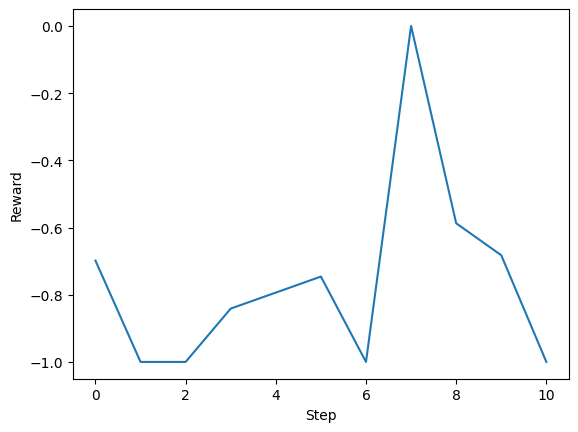

In [30]:
env_rollout = walk_through_env(env, 10)

plt.plot(env_rollout.rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.show()

# env.close()

In [31]:
env.get_cur_animation_as_html()

In [32]:
volume_size = volume_1.GetSize()

projected_env = LabelmapEnv(
    name2volume={"1": volume_1},
    observation=LabelmapSliceAsChannelsObservation(
        slice_shape=(volume_size[0], volume_size[2]),
        action_shape=(4,),
    ),
    slice_shape=(volume_size[0], volume_size[2]),
    reward_metric=LabelmapClusteringBasedReward(),
    termination_criterion=LabelmapEnvTerminationCriterion(),
    max_episode_len=10,
    rotation_bounds=(30.0, 10.0),
    translation_bounds=(0.0, None),
    render_mode="animation",
    project_actions_to="y",
)

Step::  40%|████      | 4/10 [00:00<00:00, 25.85it/s]

Walking through y-axis from -1 to 1 in 10 steps


Step:: 100%|██████████| 10/10 [00:00<00:00, 11.51it/s]


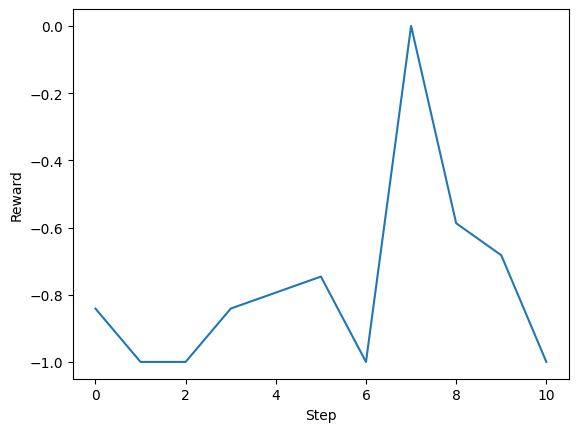

In [34]:
projected_env_rollout = walk_through_env(projected_env, 10, render_title="Projected labelmap slice")

plt.plot(projected_env_rollout.rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.show()

In [35]:
projected_env.get_cur_animation_as_html()